In [ ]:
from google.colab import files

# Upload a zip file containing data folders
uploaded = files.upload()


Saving Data.zip to Data.zip


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile
# Specify the name of the uploaded zip file
zip_filename = "Data.zip"

# Extract the contents to a specific directory (e.g., /content/data)
extract_path = "data/Data/Data/Data/Data/Data/Data/Data/Data"
train_folder = os.path.join(extract_path, 'train')
test_folder = os.path.join(extract_path, 'test')

# Unzip the file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# Function to resize an image
def resize_image(image, new_size):
    image = image.resize(new_size, Image.ANTIALIAS)
    return image

# Define the new size for your images
new_image_size = (256, 256)  # Adjust to your desired dimensions

# Function to load and preprocess your data
def load_and_preprocess_data(data_type="train"):
    images = []
    masks = []

    # Paths
    image_path = os.path.join(extract_path, data_type, "image")
    mask_path = os.path.join(extract_path, data_type, "mask")

    for filename in sorted(os.listdir(image_path)):
        if not filename.endswith('.png'):  # Adjust if your images have a different extension
            continue

        # Read Image
        img = tf.io.read_file(os.path.join(image_path, filename))
        img = tf.image.decode_png(img, channels=1)

        # Resize the image
        img = tf.image.resize(img, new_image_size)  # Resize the image

        images.append(img)

        # Read corresponding mask
        mask = tf.io.read_file(os.path.join(mask_path, filename))
        mask = tf.image.decode_png(mask, channels=1)

        # Resize the mask (if needed)
        mask = tf.image.resize(mask, new_image_size)

        masks.append(mask)

    return tf.stack(images), tf.stack(masks)

# Load Training and Test Data and preprocess
train_images, train_masks = load_and_preprocess_data(data_type="train")
test_images, test_masks = load_and_preprocess_data(data_type="test")

# Normalize Images & Masks to [0, 1]
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.cast(test_images, tf.float32) / 255.0

train_masks = tf.cast(train_masks, tf.float32) / 255.0
test_masks = tf.cast(test_masks, tf.float32) / 255.0


In [ ]:
# Define the Intersection over Union (IoU) and Dice coefficient metrics
def IoU(y_true, y_pred, smooth=1):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    iou = (intersection + smooth) / (union - intersection + smooth)
    return tf.reduce_mean(iou)

def DiceCoefficient(y_true, y_pred, smooth=1):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    dice = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) + smooth)
    return tf.reduce_mean(dice)



# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [ ]:
# U-Net architecture with improvements
def simple_unet_model_2(input_shape, num_layers=2):
    inputs = Input(input_shape)
    x = inputs
    down_layers = []
    for i in range(num_layers):
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
input_shape = (None, None, 1)  # Update according to your dataset

model_2_layers = simple_unet_model_2(input_shape, num_layers=2)
model_2_layers.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[DiceCoefficient, IoU])
history=model_2_layers.fit(train_images, train_masks, batch_size=4, epochs=75, validation_split=0.1)
layer_2_predicted = model_2_layers.predict(test_images)
dice_score = DiceCoefficient(test_masks, layer_2_predicted)
iou_score = IoU(test_masks, layer_2_predicted)

print(f"U Net Model with 2 Layers - Dice Score: {dice_score}, IoU Score: {iou_score}")



Epoch 1/75
18/18 [==============================] - 13s 232ms/step - loss: 0.6948 - DiceCoefficient: 0.2792 - IoU: 0.1666 - val_loss: 0.5703 - val_DiceCoefficient: 0.0293 - val_IoU: 0.0153
Epoch 2/75
18/18 [==============================] - 3s 193ms/step - loss: 0.4920 - DiceCoefficient: 0.5525 - IoU: 0.3873 - val_loss: 0.4319 - val_DiceCoefficient: 2.0531e-04 - val_IoU: 2.0531e-04
Epoch 3/75
18/18 [==============================] - 3s 192ms/step - loss: 0.3950 - DiceCoefficient: 0.6738 - IoU: 0.5113 - val_loss: 0.2928 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 4/75
18/18 [==============================] - 3s 189ms/step - loss: 0.3334 - DiceCoefficient: 0.7066 - IoU: 0.5492 - val_loss: 0.2919 - val_DiceCoefficient: 2.0534e-04 - val_IoU: 2.0534e-04
Epoch 5/75
18/18 [==============================] - 3s 193ms/step - loss: 0.2862 - DiceCoefficient: 0.7229 - IoU: 0.5687 - val_loss: 0.2929 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 6/75
18/18 [=========

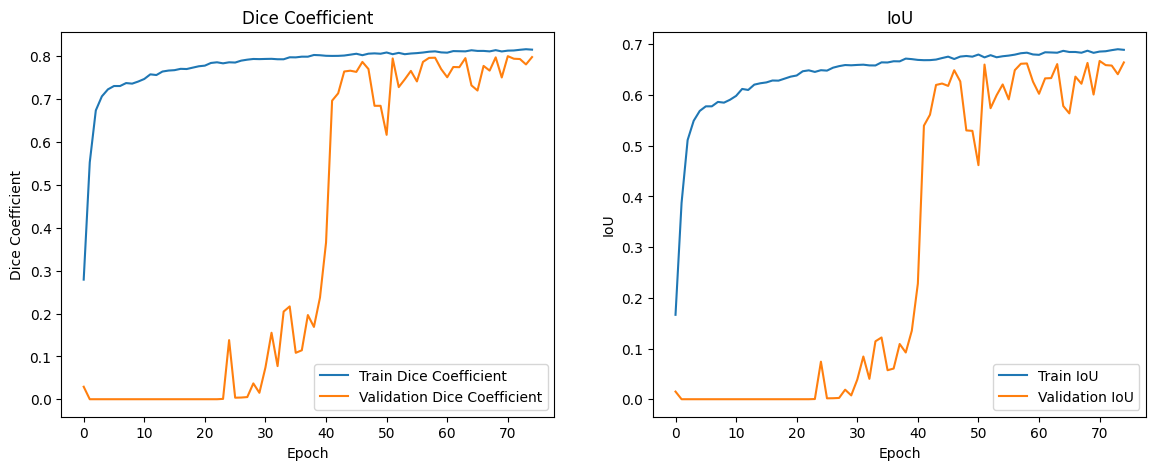

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation Dice coefficient and IoU
plt.figure(figsize=(14, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['DiceCoefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_DiceCoefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['IoU'], label='Train IoU')
plt.plot(history.history['val_IoU'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


In [ ]:
# U-Net architecture with improvements
def simple_unet_model_3(input_shape, num_layers=3):
    inputs = Input(input_shape)
    x = inputs
    down_layers = []
    for i in range(num_layers):
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

input_shape = (None, None, 1)  # Update according to your dataset

model_3_layers = simple_unet_model_3(input_shape, num_layers=2)
model_3_layers.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[DiceCoefficient, IoU])
history = model_3_layers.fit(train_images, train_masks, batch_size=4, epochs=50, validation_split=0.1)
layer_3_predicted = model_3_layers.predict(test_images)
dice_score = DiceCoefficient(test_masks, layer_3_predicted)
iou_score = IoU(test_masks, layer_3_predicted)

print(f"U Net Model with 3 Layers - Dice Score: {dice_score}, IoU Score: {iou_score}")



Epoch 1/50
18/18 [==============================] - 8s 213ms/step - loss: 0.6298 - DiceCoefficient: 0.3781 - IoU: 0.2426 - val_loss: 0.6195 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 2/50
18/18 [==============================] - 4s 206ms/step - loss: 0.4560 - DiceCoefficient: 0.6316 - IoU: 0.4655 - val_loss: 0.5917 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 3/50
18/18 [==============================] - 3s 194ms/step - loss: 0.3695 - DiceCoefficient: 0.7028 - IoU: 0.5445 - val_loss: 0.3607 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 4/50
18/18 [==============================] - 3s 194ms/step - loss: 0.3094 - DiceCoefficient: 0.7297 - IoU: 0.5769 - val_loss: 0.2934 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 5/50
18/18 [==============================] - 4s 200ms/step - loss: 0.2643 - DiceCoefficient: 0.7439 - IoU: 0.5944 - val_loss: 0.2765 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 6/50
18/18 [==

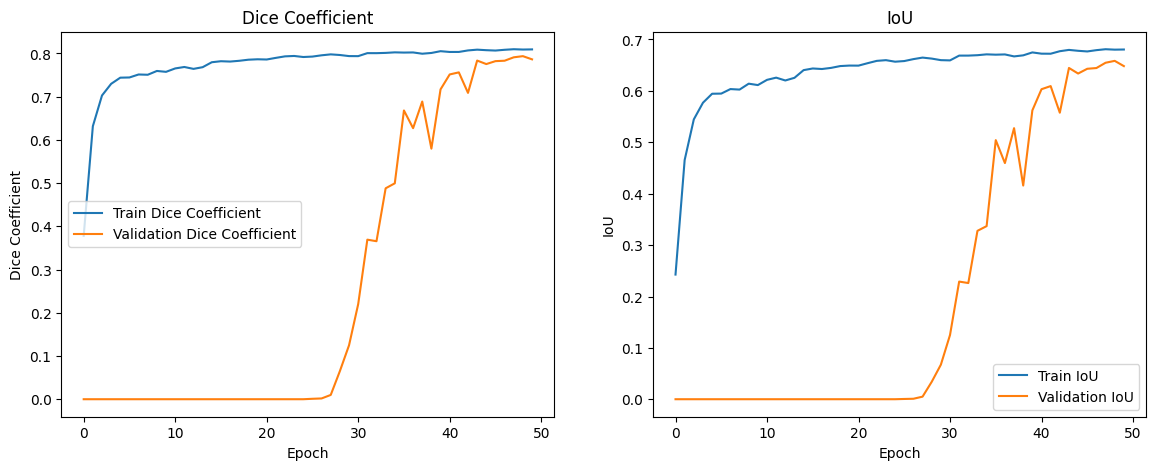

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation Dice coefficient and IoU
plt.figure(figsize=(14, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['DiceCoefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_DiceCoefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['IoU'], label='Train IoU')
plt.plot(history.history['val_IoU'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


In [ ]:
# U-Net architecture with improvements
def simple_unet_model_4(input_shape, num_layers=4):
    inputs = Input(input_shape)
    x = inputs
    down_layers = []
    for i in range(num_layers):
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

input_shape = (None, None, 1)  # Update according to your dataset

model_4_layers = simple_unet_model_4(input_shape, num_layers=2)
model_4_layers.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[DiceCoefficient, IoU])
history = model_4_layers.fit(train_images, train_masks, batch_size=4, epochs=75, validation_split=0.1)
layer_4_predicted = model_4_layers.predict(test_images)
dice_score = DiceCoefficient(test_masks, layer_4_predicted)
iou_score = IoU(test_masks, layer_4_predicted)

print(f"U Net Model with 4 Layers - Dice Score: {dice_score}, IoU Score: {iou_score}")



Epoch 1/75
18/18 [==============================] - 9s 311ms/step - loss: 0.6594 - DiceCoefficient: 0.3351 - IoU: 0.2085 - val_loss: 0.3697 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 2/75
18/18 [==============================] - 4s 197ms/step - loss: 0.4739 - DiceCoefficient: 0.6099 - IoU: 0.4432 - val_loss: 0.3943 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 3/75
18/18 [==============================] - 3s 195ms/step - loss: 0.3775 - DiceCoefficient: 0.6991 - IoU: 0.5401 - val_loss: 0.5086 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 4/75
18/18 [==============================] - 4s 201ms/step - loss: 0.3175 - DiceCoefficient: 0.7268 - IoU: 0.5731 - val_loss: 0.2930 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 5/75
18/18 [==============================] - 4s 201ms/step - loss: 0.2761 - DiceCoefficient: 0.7375 - IoU: 0.5864 - val_loss: 0.2809 - val_DiceCoefficient: 2.0535e-04 - val_IoU: 2.0535e-04
Epoch 6/75
18/18 [==

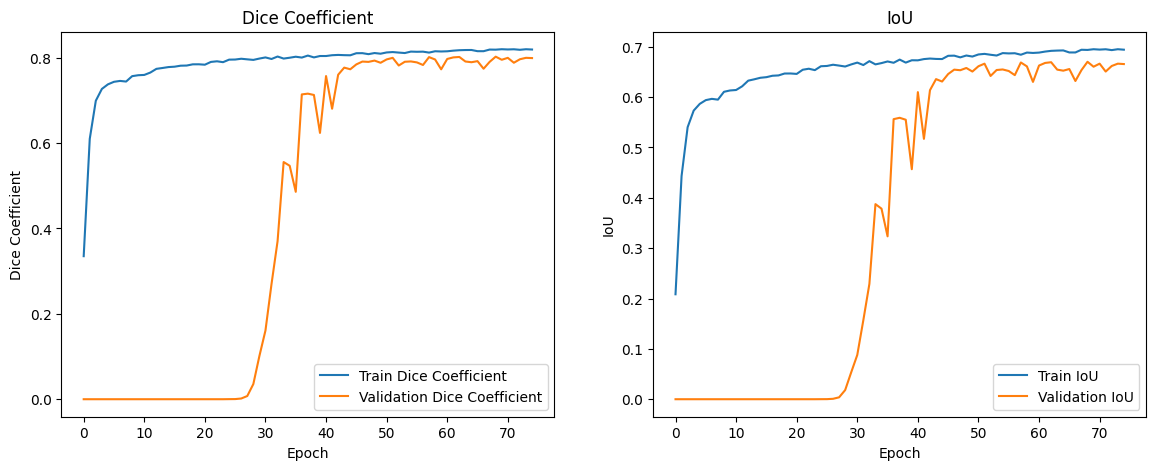

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation Dice coefficient and IoU
plt.figure(figsize=(14, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['DiceCoefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_DiceCoefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['IoU'], label='Train IoU')
plt.plot(history.history['val_IoU'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


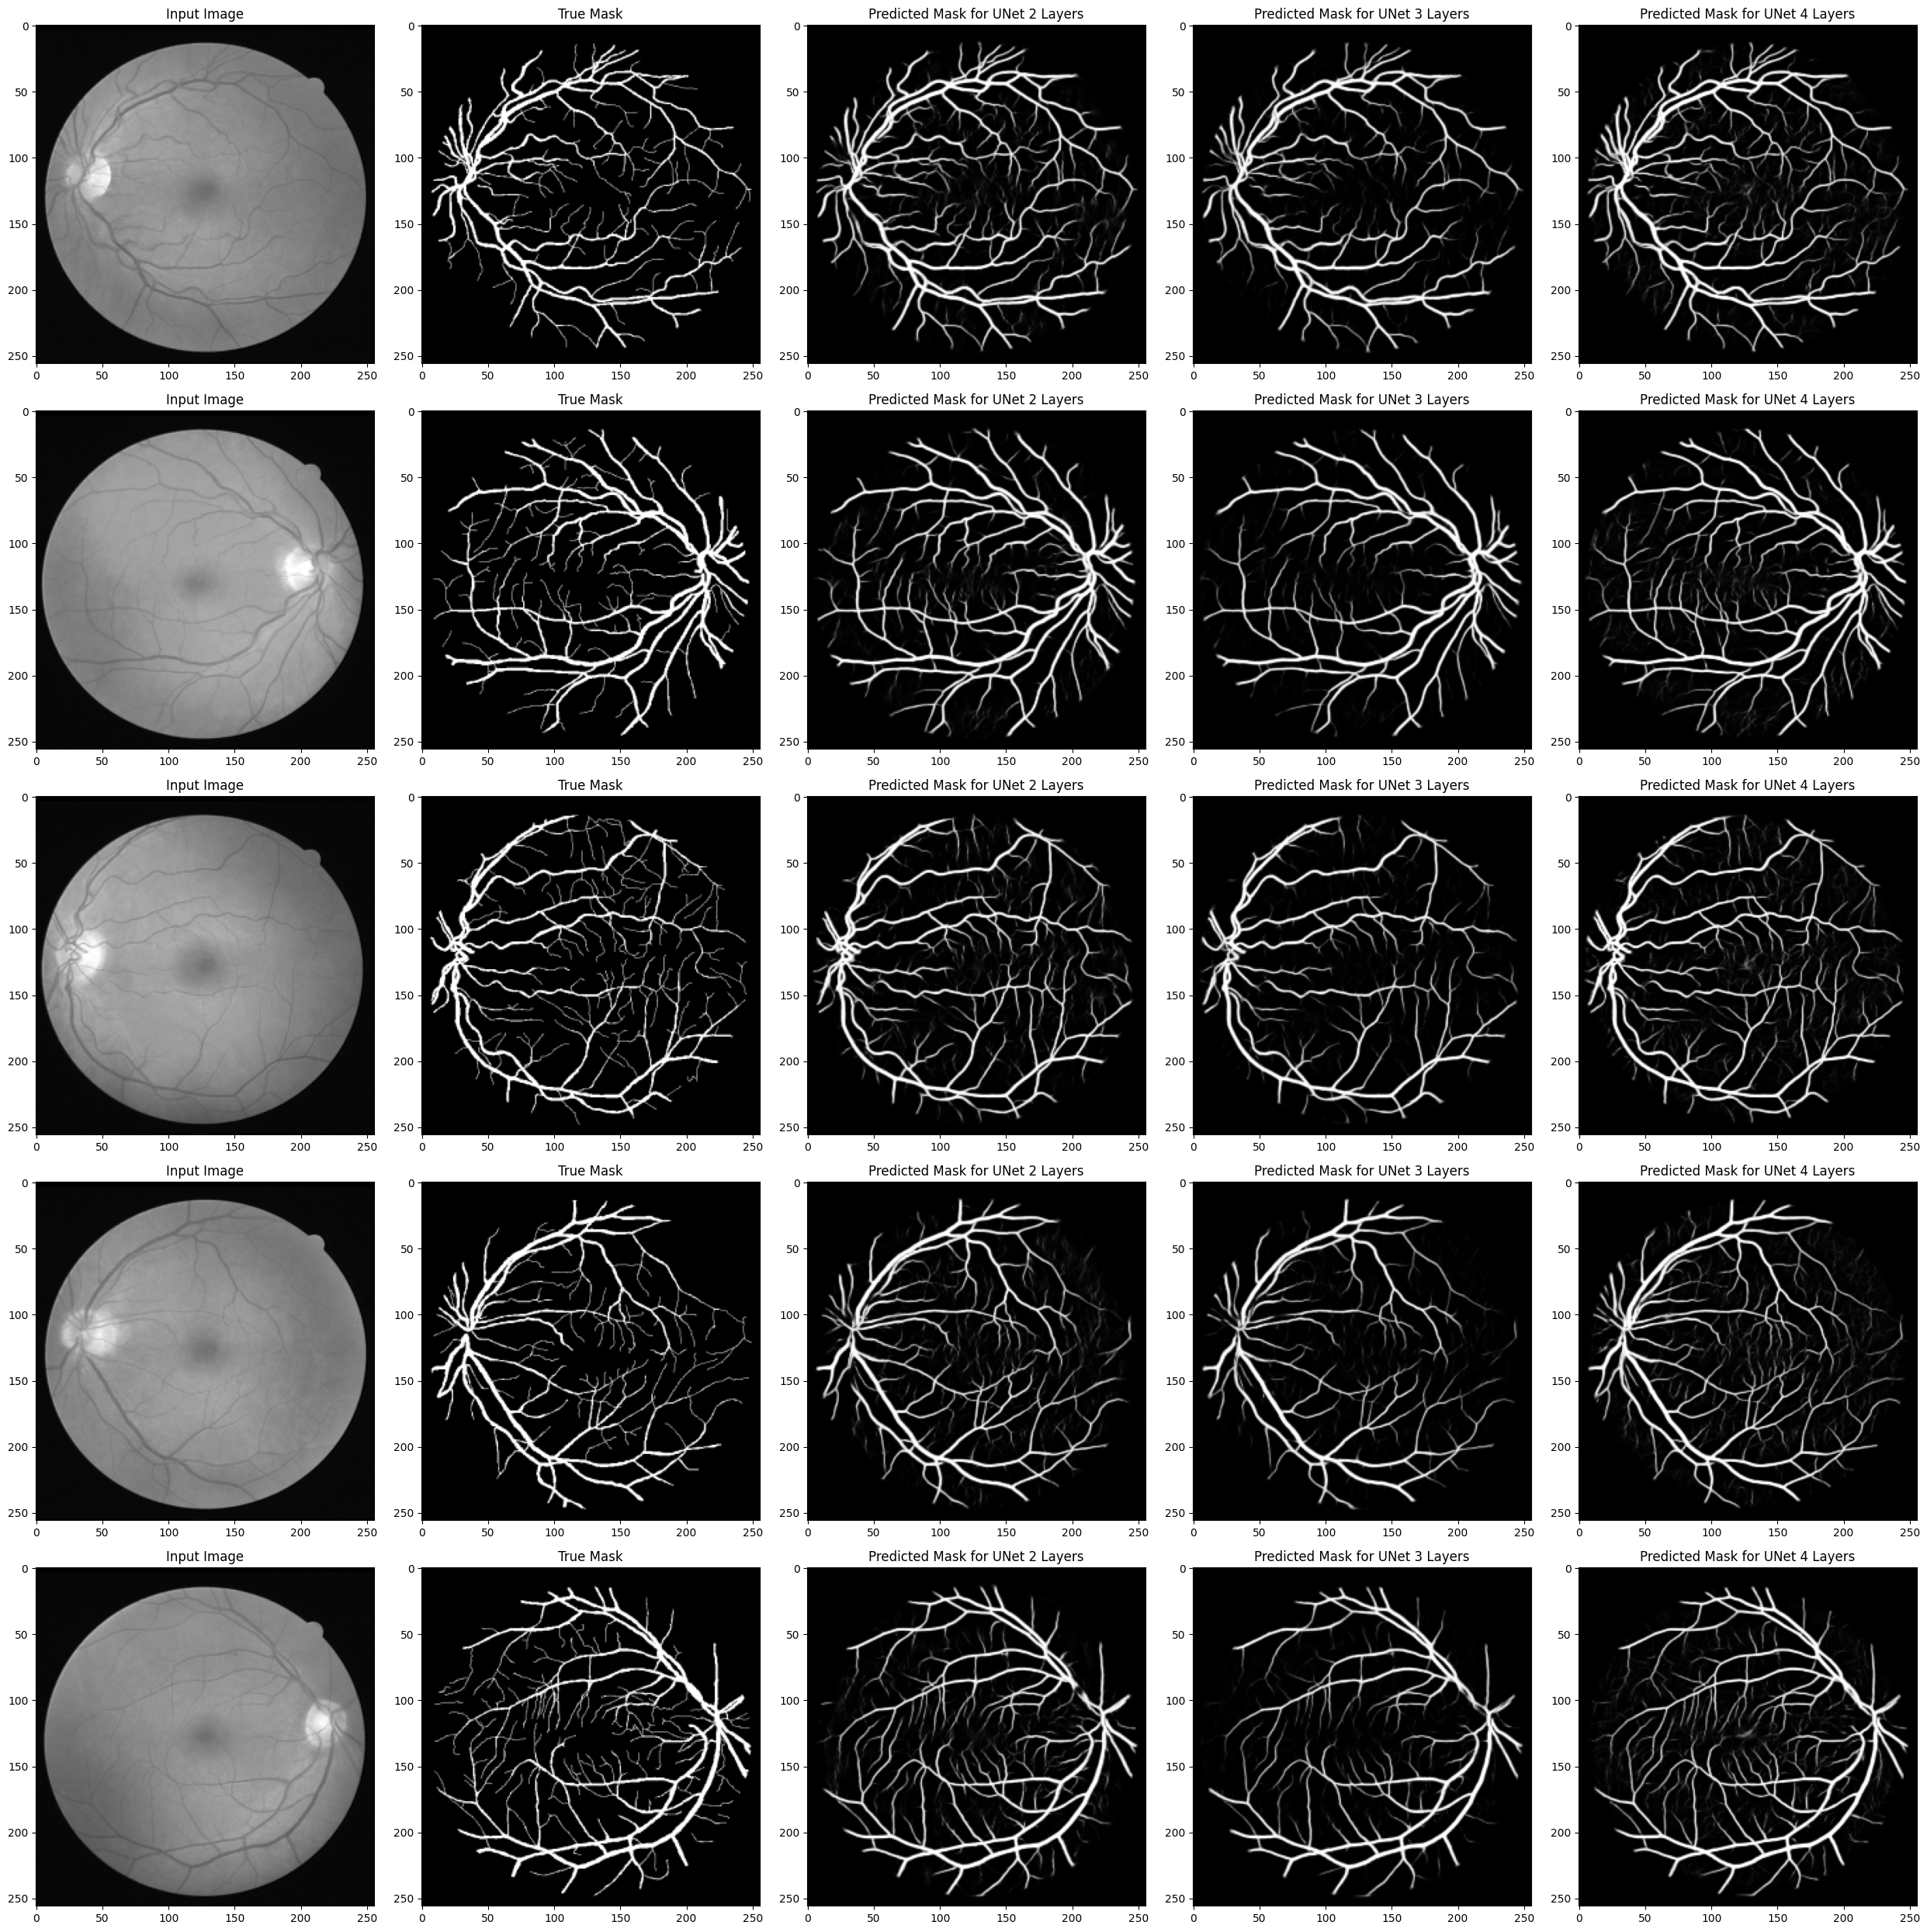

In [ ]:
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
for i in range(5):  # Change the loop range to go from 0 to 4
    ax[i, 0].imshow(test_images[i, ..., 0], cmap="gray")
    ax[i, 1].imshow(test_masks[i, ..., 0], cmap="gray")
    ax[i, 2].imshow(layer_2_predicted[i, ..., 0], cmap="gray")
    ax[i, 3].imshow(layer_3_predicted[i, ..., 0], cmap="gray")  # Add ", ..." before [0]
    ax[i, 4].imshow(layer_4_predicted[i, ..., 0], cmap="gray")  # Add ", ..." before [0]

    ax[i, 0].set_title("Input Image")
    ax[i, 1].set_title("True Mask")
    ax[i, 2].set_title("Predicted Mask for UNet 2 Layers")
    ax[i, 3].set_title("Predicted Mask for UNet 3 Layers")
    ax[i, 4].set_title("Predicted Mask for UNet 4 Layers")

plt.tight_layout()
plt.show()
